In [93]:
# Use oasi kernel
# Combine this all into a single function
import matplotlib.pyplot as plt
# from pydicom import read_file
import numpy as np
import os

# path = UDPET -> collection type -> n/a -> patient description (also from dicom file) -> dosage -> slices
path = ".\OASIS-1"
patients = os.listdir(path)
patients = [p for p in patients if '.' not in p]
print(patients)

p = patients[0]
def oasis_metadata(p):
    metadata = dict.fromkeys(['SESSION ID', 'AGE', 'M/F', 'HAND', 'EDUC', 'SES', 'CDR', 'MMSE', 'eTIV', 'ASF', 'nWBV'])
    with open(f".\OASIS-1\{p}\{p}.txt","r") as f:
        for line in f.readlines():
            l = line.strip().split(':')
            if any([m in l for m in metadata.keys()]):
                try:
                    metadata[l[0]] = float(l[1].strip())
                except ValueError:
                    match l[0]:
                        case 'M/F': 
                            metadata['MALE'] = 1 if l[1].strip() == 'Male' else 0
                        case 'HAND':
                            metadata['RIGHT'] = 1 if l[1].strip() == 'Right' else 0
                        case _:
                            metadata[l[0]] = None
    session_id = metadata['SESSION ID']
    metadata.pop('SESSION ID')
    metadata.pop('M/F')
    metadata.pop('HAND')
    return metadata
print(oasis_metadata(p))

['OAS1_0001_MR1', 'OAS1_0002_MR1', 'OAS1_0003_MR1', 'OAS1_0004_MR1', 'OAS1_0005_MR1', 'OAS1_0006_MR1', 'OAS1_0007_MR1', 'OAS1_0009_MR1', 'OAS1_0010_MR1', 'OAS1_0011_MR1', 'OAS1_0012_MR1', 'OAS1_0013_MR1', 'OAS1_0014_MR1', 'OAS1_0015_MR1', 'OAS1_0016_MR1', 'OAS1_0017_MR1', 'OAS1_0018_MR1', 'OAS1_0019_MR1', 'OAS1_0020_MR1', 'OAS1_0021_MR1', 'OAS1_0022_MR1', 'OAS1_0023_MR1', 'OAS1_0025_MR1', 'OAS1_0026_MR1', 'OAS1_0027_MR1', 'OAS1_0028_MR1', 'OAS1_0029_MR1', 'OAS1_0030_MR1', 'OAS1_0031_MR1', 'OAS1_0032_MR1', 'OAS1_0033_MR1', 'OAS1_0034_MR1', 'OAS1_0035_MR1', 'OAS1_0037_MR1', 'OAS1_0038_MR1', 'OAS1_0039_MR1', 'OAS1_0040_MR1', 'OAS1_0041_MR1', 'OAS1_0042_MR1', 'OAS1_0043_MR1', 'OAS1_0044_MR1', 'OAS1_0045_MR1', 'OAS1_0046_MR1', 'OAS1_0047_MR1', 'OAS1_0049_MR1', 'OAS1_0050_MR1', 'OAS1_0051_MR1', 'OAS1_0052_MR1', 'OAS1_0053_MR1', 'OAS1_0054_MR1', 'OAS1_0055_MR1', 'OAS1_0056_MR1', 'OAS1_0057_MR1', 'OAS1_0058_MR1', 'OAS1_0059_MR1', 'OAS1_0060_MR1', 'OAS1_0061_MR1', 'OAS1_0061_MR2', 'OAS1_0062_MR

In [1]:
from cskpd import *
from interface import *
from statsmodels.genmod.families.links import Logit, NegativeBinomial
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
with open('all_patients.pkl', 'rb') as f:
    all_patients = pickle.load(f)

In [2]:
patients_df = pd.DataFrame(columns=['id', 'AGE', 'MALE', 'nWBV', 'scans', 'MMSE'])
for p in all_patients.values():
    patients_df = pd.concat([patients_df, pd.DataFrame.from_records([{ 
        'id': p['xnat:subject_ID'], 
        'AGE': p['metadata']['AGE'], 
        'MALE': p['metadata']['MALE'],  
        'nWBV': p['metadata']['nWBV'], 
        'scans': p['xnat:scans'], 
        'MMSE': p['metadata']['MMSE']
    }])], ignore_index=True)
display(patients_df.head())
print(f"Total Records: {patients_df.shape[0]}")
impute_val = np.average(patients_df['MMSE'][(-np.isnan(patients_df['MMSE'])) & (patients_df['AGE'] < 60)])
patients_df['MMSE'][np.isnan(patients_df['MMSE'])] = impute_val
display(patients_df.head())

part_vals = range(patients_df.shape[0])
z_part = patients_df[['AGE','MALE','nWBV']].loc[part_vals]
y_part = np.asarray(patients_df['MMSE'].loc[part_vals])
# model = SKPDRegressor(impute=impute_val)

all_patients['OAS1_0001_MR1']['xnat:scans']['xnat:scan'][0]['tensor']

# Grab a scan at random from each patient
scans = [x['xnat:scan'][np.random.choice(range(len(x['xnat:scan'])))] for x in dict(patients_df['scans']).values()]
X_all = pd.Series([x['tensor'] for x in scans])
Y_all = np.asarray(patients_df['MMSE'])
Z_all = patients_df[['AGE','MALE','nWBV']]
cov_3d = pd.concat([Z_all, X_all], axis=1)
cov_3d = cov_3d.rename(columns={cov_3d.columns[-1]: 'X'})
cov_2d = pd.concat([Z_all, pd.Series([x['views'] for x in scans])], axis=1)
cov_2d = cov_2d.rename(columns={cov_2d.columns[-1]: 'X'})

C:\Users\joshu\AppData\Local\Temp\ipykernel_55408\918886627.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  patients_df = pd.concat([patients_df, pd.DataFrame.from_records([{


,id,AGE,MALE,nWBV,scans,MMSE
0,OAS1_0001,74.0,0,0.743,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",29.0
1,OAS1_0002,55.0,0,0.810,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",29.0
2,OAS1_0003,73.0,0,0.708,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",27.0
3,OAS1_0004,28.0,1,0.803,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",NaN
4,OAS1_0005,18.0,1,0.848,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",NaN


Total Records: 436


C:\Users\joshu\AppData\Local\Temp\ipykernel_55408\918886627.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  patients_df['MMSE'][np.isnan(patients_df['MMSE'])] = impute_val
C:\Users\joshu\AppData\Local\Temp\ipykernel_55408\918886627.py:1

,id,AGE,MALE,nWBV,scans,MMSE
0,OAS1_0001,74.0,0,0.743,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",29.000000
1,OAS1_0002,55.0,0,0.810,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",29.000000
2,OAS1_0003,73.0,0,0.708,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",27.000000
3,OAS1_0004,28.0,1,0.803,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",29.459459
4,OAS1_0005,18.0,1,0.848,"{'xnat:scan': [{'@ID': 'mpr-1', '@type': 'MPRA...",29.459459


In [90]:
np.mean(np.log(patients_df['MMSE']))
# np.var(np.log(patients_df['MMSE']))

3.3312313988520077

In [8]:
from scipy.signal import convolve2d
horizontal_kernel = np.array([[-1, 0, 1],
                              [-2, 0, 2],
                              [-1, 0, 1]])
cor = [convolve2d(x['cor'], horizontal_kernel, mode='same') for x in cov_2d['X']]

In [9]:
cor[0].shape

(96, 96)

In [10]:
g = NegativeBinomial()
## lambda 1 candidate, corresponds to the lambda in the paper
lmbda_set = [0.01,0.4,0.6,1]
## We set lambda2 equals 0 all the time in the paper.
lmbda2_set = [0]
## tuning R in this candidate set
## We refer to implement R = 1 first when smaple size is limited
R_list = [1,2,3]
n_cores = 4
## the dim of underlying C is (D1,D2,D3), which satisfies D1 = p1 * d1, D2 = p2 * d2 and D3 = p3 * d3 
p_list = [[24,24]]
d_list = [[4,4]]
input_params = {
    "p_list":p_list,
    "d_list":d_list,
    "lmbda_set":lmbda_set,
    "lmbda2_set":lmbda2_set,
    ## Z_train is None, when not consider covariate
    "Z_train":None,
    "X_train":cor,
    "Y_train":g(Y_all),
    ## n_cores is the number of cores for parallel computing, when n_cores = None, we only use a single core in our paper
    ## you can use n_cores > 1 for accelerating your computing
    "R_list":R_list, "n_cores":n_cores,"max_iter":20,"print_iter":30}
    # p_list,d_list,lmbda_set,lmbda2_set,Z_train,X_train,Y_train,R_list,n_cores = -1,max_iter = 20,print_iter = 5, cuda=False
a_hat,b_hat,gamma_hat,lmbda_1,lmbda_2,R,p,d = skpdRegressor(**input_params)

-------start parallel computing-----------
MBIC values:  [-1411.4239094032005, -1080.2606771421488, -941.6920239651126, -3692.4665131934785, -3736.7008821819454, -3765.699402855, -3699.477087313152, -3779.361135952301, -3702.5316856934323, -3632.749021951218, -3789.7829003407733, -3702.418003594289]


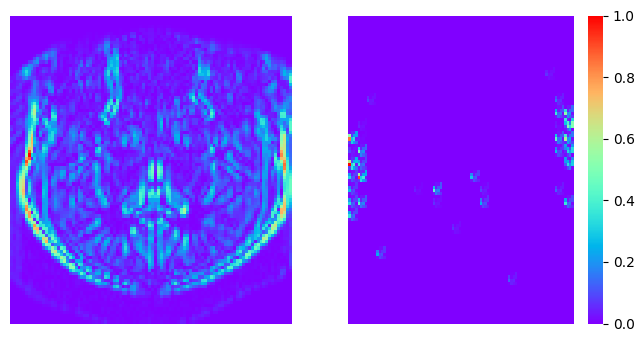

In [11]:
def RMSE_C(C_hat,C):
    ## estimation error in statistics
    d1,d2 = C.shape
    c1 = C_hat.reshape(d1*d2,-1)
    c2 = C.reshape(d1*d2,-1)
    res = la.norm(c1.squeeze()-c2.squeeze(),2) / np.sqrt(d1 *d2)
    return res
def RMSE_tensor(C_hat,C):
    m,n,d = C.shape
    c1 = C_hat.reshape(m*n*d,-1)
    c2 = C.reshape(m*n*d,-1)
    res = la.norm(c1.squeeze()-c2.squeeze(),2) / np.sqrt(m*n*d)
    return res
def error(beta_hat,beta,th = 0):
    ## non-threshold version
    ## return typeI error and Power
    # rmse_c = RMSE_C(beta_hat,beta)
    _len = beta.shape
    if len(_len)== 2:
        rmse_c = RMSE_C(beta_hat,beta)
        m,n = beta.shape
    else:
        rmse_c = RMSE_tensor(beta_hat,beta)
        m,n,d = beta.shape
    beta =  np.where(np.abs(beta) == 0 ,beta,1)
    beta_hat = np.asarray(beta_hat)
    if th == 0:
        tmp = np.where(np.abs(beta_hat) == 0 ,beta_hat,1)
    else:
        tmp = np.where(np.abs(beta_hat) > th,beta_hat,0)
        tmp = np.where(np.abs(tmp) < th,tmp,1)
    diff = beta - tmp
    mul = beta * tmp
    typeI = np.where(diff == -1)[0].shape[0]/np.where(beta == 0)[0].shape[0]
    Power = np.where(mul == 1)[0].shape[0]/np.where(beta == 1)[0].shape[0]
    return typeI,Power,rmse_c

A,B,kron_ab = func_kron_ab(a_hat,b_hat,R,p,d)
C_hat = kron_ab[-1]

def fun_normalization(data):
    data = np.abs(data)
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

plt.figure(figsize= (8,4))
ax = plt.subplot(1,2,1)
sns.heatmap(fun_normalization(cor[3]),cmap = "rainbow",cbar = False)
ax.set_xticks([])
ax.set_yticks([])
ax = plt.subplot(1,2,2)
sns.heatmap(fun_normalization(C_hat),cmap = "rainbow",cbar = True)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [80]:
from scipy.signal import convolve2d
class SKPDRegressor(RegressorMixin, BaseEstimator):
    def __init__(self,p_list,d_list,lmbda_set,lmbda2_set,R_list,n_cores = -1,max_iter = 20,print_iter = 5,cuda=False,g=Identity,K=None,L=None):
        self.p_list = p_list
        self.d_list = d_list
        self.lmbda_set = lmbda_set
        self.lmbda2_set = lmbda2_set
        self.R_list = R_list
        self.n_cores = n_cores
        self.max_iter = max_iter
        self.print_iter = print_iter
        self.cuda = cuda
        self.g = g
        self.K = K
        self.L = L

    def fit(self, X, y):
        if self.K is not None:
            X = [convolve2d(x, self.K, mode='same') for x in X]
            self.xk = X
        input_params = {
            "p_list":self.p_list,
            "d_list":self.d_list,
            "lmbda_set":self.lmbda_set,
            "lmbda2_set":self.lmbda2_set,
            ## Z_train is None, when not consider covariate
            "Z_train":None,
            "X_train":X,
            "Y_train":self.g(y),
            ## n_cores is the number of cores for parallel computing, when n_cores = None, we only use a single core in our paper
            ## you can use n_cores > 1 for accelerating your computing
            "R_list":self.R_list, "n_cores":self.n_cores,"max_iter":self.max_iter,"print_iter":self.print_iter}
            # p_list,d_list,lmbda_set,lmbda2_set,Z_train,X_train,Y_train,R_list,n_cores = -1,max_iter = 20,print_iter = 5, cuda=False
        a_hat,b_hat,self.gamma_hat,self.lmbda_1,self.lmbda_2,self.R,self.p,self.d = skpdRegressor(**input_params) 
        A,B,kron_ab = func_kron_ab(a_hat,b_hat,self.R,self.p,self.d)
        self.C_hat = kron_ab[-1]
        return self
    
    def predict(self, X):
        if self.K is not None:
            X = [convolve2d(x, self.K, mode='same') for x in X]
        y_hat = [self.g.inverse(np.vdot(x,self.C_hat)) for x in X]
        return y_hat
    
def rmse(y_true, y_pred):
    idx = ~np.isnan(y_true)
    return -mean_squared_error(y_true[idx], np.round(y_pred[idx],0), squared=False)

def acc_new(y_true, y_pred):
    # idx = ~np.isnan(y_true)
    # print(f"y_true: {y_true[idx]}, y_pred: {y_pred[idx]}")
    return np.mean((y_true>24)==(y_pred>24))

def custom_auc(cutoff_point=0):
    def auc(y_true, y_pred):
        idx = ~np.isnan(y_true)
        y_pred_relu = y_pred * (np.array(y_pred)>cutoff_point)
        y_pred_softmax = np.exp(np.array(y_pred_relu - np.max(y_pred_relu)).astype(np.float64)) / np.sum(np.exp(np.array(y_pred_relu - np.max(y_pred_relu)).astype(np.float64)))
        return roc_auc_score(list(np.array(y_true[idx])>cutoff_point), y_pred_softmax[idx])
    return auc

def custom_accuracy(cutoff_point=0):
    def accuracy(y_true, y_pred):
        idx = ~np.isnan(y_true)
        return np.average((np.array(y_true[idx])>cutoff_point)==(np.array(y_pred[idx])>cutoff_point))
    return accuracy

def calc_score(model, X, y, k_folds=5, y_imputer=None, cutoff_point=0):
    scorers = {
        # 'acc_new': make_scorer(acc_new, greater_is_better=True),
        # 'rmse': make_scorer(rmse, greater_is_better=False),
        'auc': make_scorer(custom_auc(24), greater_is_better=True),
        # 'accuracy': make_scorer(custom_accuracy(24), greater_is_better=True),
    }
    if y_imputer is not None:
        y = y_imputer.transform(y)
    results = cross_validate(model, X, y, cv=k_folds, scoring=scorers, return_estimator=True)
    # print("5-Fold CV Accuracy Scores: ", results['test_acc_new'])
    # print("Average 5-Fold CV RMSE Scores: ", np.nanmean(np.array(results['test_acc_new'])))
    # print("5-Fold CV Accuracy Scores: ", results['test_accuracy'])
    # print("5-Fold CV RMSE Scores: ", results['test_rmse'])
    print("5-Fold CV AUC Scores: ", results['test_auc'])
    # print("Average 5-Fold CV Accuracy: ", np.nanmean(results['test_accuracy']))
    # print("Average 5-Fold CV RMSE: ", np.nanmean(results['test_rmse']))
    print("Average 5-Fold CV AUC: ", np.nanmean(np.array(results['test_auc'])))
    return results

In [44]:
y_hat = model1.predict(cor)
print(y_hat)

[26.054178514919933, 30.168339612161105, 26.91849520100056, 29.855271921435723, 34.28437384788795, 25.632402954971855, 30.746750650376264, 27.47210235140194, 27.682330451615353, 33.36914628370358, 348.2770443437432, 35.71573825410875, 30.648500039552655, 37.010887103541705, 25.26319427580371, 28.276285685988437, 28.511393647581208, 439.3535857898166, 33.02509968293365, 26.995325642036008, 59.8621382175649, 29.118523392046594, 31.583216602017497, 43.59672697446272, 25.2554419057098, 22.084186801673443, 30.281097936201444, 24.771121928421117, 25.125884870721233, 31.732752969529873, 34.29773918804799, 31.2279116899477, 31.943094108416116, 21.404121730038472, 28.635668963540457, 25.51982737044928, 23.264839508351, 37.59032084650406, 49.07122459600241, 27.986365234249945, 36.440214269761576, 27.454092726279686, 23.10522564991913, 25.49550759837609, 32.53512853900297, 30.095486596381928, 28.292094258350396, 25.812123849840557, 23.09731177531764, 31.965979813577338, 32.887617560845236, 18.937

In [41]:
Y_all[~np.isnan(Y_all)]

array([29.        , 29.        , 27.        , 29.45945946, 29.45945946,
       29.45945946, 29.45945946, 29.45945946, 30.        , 30.        ,
       29.45945946, 30.        , 29.45945946, 28.        , 27.        ,
       29.45945946, 28.        , 30.        , 29.        , 23.        ,
       23.        , 27.        , 29.45945946, 30.        , 29.45945946,
       27.        , 29.45945946, 29.        , 26.        , 28.        ,
       29.        , 29.        , 28.        , 29.45945946, 29.45945946,
       29.        , 29.45945946, 28.        , 29.        , 29.45945946,
       30.        , 29.45945946, 22.        , 29.45945946, 29.45945946,
       29.45945946, 29.45945946, 23.        , 21.        , 29.45945946,
       29.45945946, 15.        , 29.45945946, 30.        , 29.45945946,
       29.        , 29.45945946, 29.45945946, 30.        , 29.45945946,
       29.        , 25.        , 28.        , 27.        , 30.        ,
       30.        , 30.        , 30.        , 30.        , 21.  

In [ ]:
g = NegativeBinomial()
## lambda 1 candidate, corresponds to the lambda in the paper
lmbda_set = [0.01,0.4,0.6,1]
## We set lambda2 equals 0 all the time in the paper.
lmbda2_set = [0]
## tuning R in this candidate set
## We refer to implement R = 1 first when smaple size is limited
R_list = [1,2,3]
n_cores = 4
## the dim of underlying C is (D1,D2,D3), which satisfies D1 = p1 * d1, D2 = p2 * d2 and D3 = p3 * d3 
p_list = [[24,24]]
d_list = [[4,4]]

In [59]:
np.argmax(Y_all)
np.argmin(Y_all)

344

In [60]:
cor[np.argmax(Y_all)]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

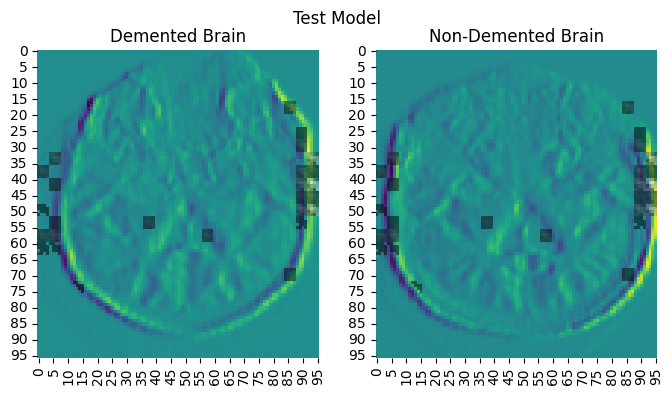

In [84]:
# Create a custom colormap to hide 0 values
import matplotlib.colors as mcolors
cmap = plt.cm.gray
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0 # first color transparency
cmap[1:, -1] = 0.5 # alpha value
custom_cmap = mcolors.ListedColormap(cmap)
def plot_model(name, model_results, X, y, cutoff_point=0):
    C_hat = model_results['estimator'][np.argmax(model_results['test_auc'])].C_hat

    fig = plt.figure(figsize=(8,4))
    # Demented Brain
    plt.subplot(1, 2, 1)
    sns.heatmap(X[np.argmin(y)], cmap='viridis', cbar=False)
    sns.heatmap(np.abs(C_hat), cmap=custom_cmap, cbar=False)  # Assuming grayscale or using first channel for RGB
    plt.title('Demented Brain')

    # Non-Demented Brain
    plt.subplot(1, 2, 2)
    sns.heatmap(X[np.argmax(y)], cmap='viridis', cbar=False)
    sns.heatmap(np.abs(C_hat), cmap=custom_cmap, cbar=False)  # Assuming grayscale or using first channel for RGB
    plt.title('Non-Demented Brain')

    fig.suptitle(name)

    plt.show()
plot_model("Test Model", model1_results, cor, Y_all)

In [ ]:
print("Test Model")
model1 = SKPDRegressor(p_list,d_list,lmbda_set,lmbda2_set,R_list,n_cores,max_iter = 20,g=g)
model1_results = calc_score(model1, cor, Y_all)

Test Model
-------start parallel computing-----------
MBIC values:  [-1411.4239094032005, -1080.2606771421488, -941.6920239651126, -3692.4665131934785, -3736.7008821819454, -3765.699402855, -3699.477087313152, -3779.361135952301, -3702.5316856934323, -3632.749021951218, -3789.7829003407733, -3702.418003594289]
--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-903.7488162535014, -550.1983850228562, -555.6090768778108, -2771.459666844265, -2806.3316386427196, -2830.200618856752, -2741.631223921367, -2852.52481764029, -2963.357195581016, -2793.780077321116, -2926.9988170914644, -2966.942254861735]
--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-1098.814184578359, -799.0749344264714, -553.3038271785986, -2824.3544292840693, -2839.3858093420085, -2797.7188689472828, -2879.5390105944794, -2952.8367781939646, -2813.6459129641235, -2854.946629391811, -2971.7772359440646, -2943.673052

C:\Users\joshu\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-03, tolerance: 4.470e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\joshu\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.555e-04, tolerance: 4.470e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\joshu\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-821.6128855098086, -913.8617948843626, -619.082907930248, -2875.9964255364193, -2886.0121281925067, -2783.137153191136, -2842.4025179430328, -2954.914160246963, -2798.609688434307, -2878.341031171457, -2973.3833268108933, -2922.378229144512]
--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-1044.6406143279924, -811.2614455278922, 24.819245290950676, -2899.2059858306716, -2927.889963157695, -2781.9100645227077, -2917.739015162757, -3075.7972964796363, -2941.9183629979843, -2911.662965395233, -2926.3597355948286, -2927.6617668746485]
--------------enough iteration---------------
5-Fold CV AUC Scores:  [0.7292769  0.49375    0.55194805 0.63157895 0.43777778]
Average 5-Fold CV AUC:  0.5688663346075626


Test Model 2
-------start parallel computing-----------
MBIC values:  [-903.7488162535014, -550.1983850228562, -555.6090768778108, -2771.459666844265, -2806.3316386427196, -2830.200618856752, -2741.631223921367, -2852.52481764029, -2963.357195581016, -2793.780077321116, -2926.9988170914644, -2966.942254861735]
--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-1098.814184578359, -799.0749344264714, -553.3038271785986, -2824.3544292840693, -2839.3858093420085, -2797.7188689472828, -2879.5390105944794, -2952.8367781939646, -2813.6459129641235, -2854.946629391811, -2971.7772359440646, -2943.6730529434153]
--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-1049.237570688178, -845.4023492936421, -473.79844332457833, -2877.1067579235523, -2942.40058795663, -2922.340545965358, -2903.990849568019, -2842.1063400258117, -2835.5245504172844, -2865.2217053270297, -2919.5585925622313, -2885.3

C:\Users\joshu\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-03, tolerance: 4.470e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\joshu\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.555e-04, tolerance: 4.470e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\joshu\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-821.6128855098086, -913.8617948843626, -619.082907930248, -2875.9964255364193, -2886.0121281925067, -2783.137153191136, -2842.4025179430328, -2954.914160246963, -2798.609688434307, -2878.341031171457, -2973.3833268108933, -2922.378229144512]
--------------enough iteration---------------
-------start parallel computing-----------
MBIC values:  [-1044.6406143279924, -811.2614455278922, 24.819245290950676, -2899.2059858306716, -2927.889963157695, -2781.9100645227077, -2917.739015162757, -3075.7972964796363, -2941.9183629979843, -2911.662965395233, -2926.3597355948286, -2927.6617668746485]
--------------enough iteration---------------
5-Fold CV AUC Scores:  [0.7292769  0.49375    0.55194805 0.63157895 0.43777778]
Average 5-Fold CV AUC:  0.5688663346075626


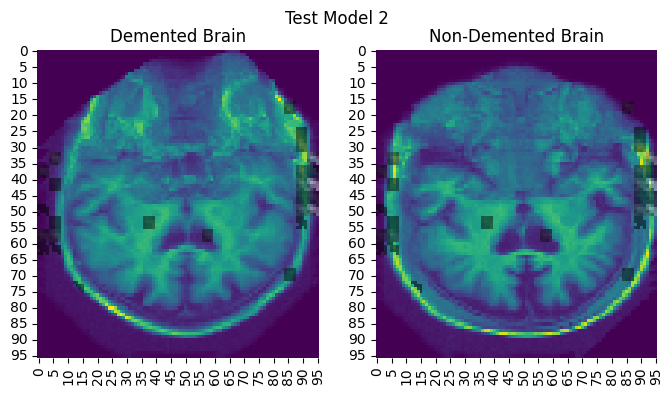

In [85]:
cor_test = [x['cor'] for x in cov_2d['X']]
horizontal_kernel = np.array([[-1, 0, 1],
                              [-2, 0, 2],
                              [-1, 0, 1]])
name = "Test Model 2"
print(name)
model2 = SKPDRegressor(p_list,d_list,lmbda_set,lmbda2_set,R_list,n_cores,max_iter = 20,g=g,K=horizontal_kernel)
model2_results = calc_score(model2, cor_test, Y_all)
plot_model(name, model2_results, cor_test, Y_all)